# Problem Set 3

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

%matplotlib inline

# Question 2

## Roy Model of Schooling Choice
Consider thhe model of schooling choice ($D=1$ if college; $D=0$ if high school):

$$\mathrm{Y}_{1}=\alpha+\bar{\beta}+\mathrm{U}_{1} \quad \text{P.V. of income from college}$$

$$\mathrm{Y}_{0}=\alpha+\mathrm{U}_{0} \quad \text{P.V. of income from high school}$$

$$\mathrm{D}=\mathbf{1}\left\{\mathrm{Y}_{1}-\mathrm{Y}_{0}-\mathrm{C} \geq 0\right\}$$

$$\left.\left(\begin{array}{c}\mathrm{U}_{0} \\ \mathrm{U}_{1} \\ \mathrm{V}\end{array}\right) \sim \mathcal{N}\left(\begin{array}{ccc}\sigma_{0}^{2} & \sigma_{01} & \sigma_{0, \mathrm{V}} \\ \sigma_{01} & \sigma_{1}^{2} & \sigma_{1, \mathrm{V}} \\ \sigma_{0, \mathrm{V}} & \sigma_{1, \mathrm{V}} & \sigma_{\mathrm{V}}^{2}\end{array}\right]\right)$$

$$\mathrm{C}=\mathrm{Z}+\mathrm{V}, \quad \mathrm{Z} \text{ is tuition; } V \text{ is psychic costs}$$


\begin{array}{c}
\mathrm{Z} \perp\left(\mathrm{U}_{0}, \mathrm{U}_{1}, \mathrm{V}\right) \\
\mathrm{U}_{D}=\Phi\left(\frac{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}{\sigma_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}}\right) \\
\alpha=0.67, \quad \bar{\beta}=0.2
\end{array}

For this model we have several configarations which are described below with $\Theta$, where
$$\Theta = [\sigma^2_1,\sigma^2_0,\sigma^2_V,\sigma_{01},\sigma_{0V},\sigma_{1V}]$$

In [131]:
#configurations
Θ_1 = [1, 1, 1, 0, 0, 0]

Θ_2 = [1, 1, 1, 0.5, -0.5, 0]

Θ_3 = [1, 1, 1, 0, 0, 0.5]

Θ_4 = [1, 1, 0, 0.5, 0, 0]

Θ_5 = [1, 0.25, 1, 0.1, -0.2, 0.2]

Θ_6 = [0.25, 0.25, 1, -0.2, 0.1, -0.2]

Θ_7 = [1, 1, 1, -0.2, 0.6, 0.5]

## Marginal treatment effect (MTE)
The MTE is a parameter which is defined as,
$$\Delta^{MTE}(u_D) = \mathbb{E}[Y_1 - Y_0 | U_D = u_d]$$
Given the assumptions above we can derive a closed form expression for $\Delta^{MTE}$.
\begin{align*}
    \Delta^{MTE}(u_D) =& \bar \beta  + \mathbb{E}\left[U_1-U_0\Big|\frac{U_1-U_0-V}{\sigma_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}} = \Phi^{-1}(u_D) \right]\\
    =& \bar \beta  + Cov\left(U_1-U_0,\frac{U_1-U_0-V}{\sigma_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}}\right) \Phi^{-1}(u_D)\\
    =& \bar \beta  + \frac{\gamma}{\sigma_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}} \Phi^{-1}(u_D)\\
\end{align*}
where $\gamma = \sigma_1^2 + \sigma_0^2 + \sigma_{V0} - 2\sigma_{10}-\sigma_{V1}$, and we can evaluate $\sigma_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}$ as,
$$\sigma^2_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}} = \begin{pmatrix} -1 , 1, -1 \end{pmatrix}\begin{pmatrix}\sigma_{0}^{2} & \sigma_{01} & \sigma_{0, \mathrm{V}} \\ \sigma_{01} & \sigma_{1}^{2} & \sigma_{1, \mathrm{V}} \\ \sigma_{0, \mathrm{V}} & \sigma_{1, \mathrm{V}} & \sigma_{\mathrm{V}}^{2}\end{pmatrix}\begin{pmatrix} -1\\1\\ -1 \end{pmatrix}= \sigma^2_0 + \sigma^2_1 + \sigma^2_V - 2(\sigma_{01} + \sigma_{1V} - \sigma_{0V})$$

The code below calculates the MTE for a given set of $u_d$'s.

In [132]:
##Define MTE function## 
def MTE(u_d= np.linspace(0.001,0.999,200), β =0.2 , Θ=[1,1,1,0,0,0]):
    
    # for ease of notation σ_i denote variance
    σ_1, σ_0, σ_v, σ_01, σ_0v, σ_1v = Θ[0],Θ[1],Θ[2],Θ[3],Θ[4],Θ[5]
    
    #calculate parameters needed to evaluate
    γ = σ_1 + σ_0 + σ_0v - 2*σ_01 - σ_1v
    σ = (σ_1 + σ_0 + σ_v - 2*(σ_01 + σ_1v - σ_0v))**0.5 #this is standard deviation
    
    MTE = [β + (γ/σ)*norm.ppf(u) for u in u_d]
    
    return MTE,u_d

## Local Instrument Variable

A local instrument variable is defined as,
$$LIV = \frac{\partial \mathbb{E}[Y|P(Z)=p]}{\partial p}$$

We begin by finding an expression of the expression $\mathbb{E}[Y|P(Z)=p]$
\begin{align*}
    \mathbb{E}[Y|P(z) = p] =& \mathbb{E}[Y_0 + D(Y_1 - Y_0) | P(Z) = p]\\
                           =& \mathbb{E}[Y_1|D=1, P(Z) = p]P(D=1|Z=z)\\
                           =& \mathbb{E}[Y_1|P(Z)>U_D, P(Z) = p]p\\
                           =& \alpha + \bar \beta + \mathbb{E}[U_1|p>U_D]p\\
                           =& \alpha + \bar \beta + \mathbb{E}\left[U_1\Big|\frac{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}{\sigma_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}}<\Phi^{-1}(p) \right]p\\
                           =& \alpha + \bar \beta + \frac{\zeta}{\sigma_{U_1 - U_0 - V}} \mathbb{E}\left[\frac{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}{\sigma_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}}\Big|\frac{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}{\sigma_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}}<\Phi^{-1}(p) \right]p\\
                           =& \alpha + \bar \beta + \frac{\zeta}{\sigma_{U_1 - U_0 - V}}  \frac{\mathbb{E}\left[\frac{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}{\sigma_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}}\mathbf{1}\left\{\frac{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}{\sigma_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}}<\Phi^{-1}(p)\right\} \right]}{P\left(\frac{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}{\sigma_{\mathrm{U}_{1}-\mathrm{U}_{0}-\mathrm{V}}}<\Phi^{-1}(p)\right)}p\\
                           =& \alpha + \bar \beta + \frac{\zeta}{\sigma_{U_1 - U_0 - V}} \frac{\int_{-\infty}^{\Phi^{-1}(p)}t\phi(t)dt}{\int_{-\infty}^{\Phi^{-1}(p)}\phi(t)dt}p = \alpha + \bar \beta - \zeta\frac{\int_{-\infty}^{\Phi^{-1}(p)}\phi'(t)dt}{\int_{-\infty}^{\Phi^{-1}(p)}\phi(t)dt}p \tag{$\phi'(t) = -t\phi(t)$}\\
                           =& \alpha + \bar \beta - \frac{\zeta}{\sigma_{U_1 - U_0 - V}} \frac{\phi(\Phi^{-1}(p))}{\Phi(\Phi^{-1}(p))}p\\
                           =&  \alpha + \bar \beta - \frac{\zeta}{\sigma_{U_1 - U_0 - V}} \phi(\Phi^{-1}(p))
\end{align*}
where $\zeta = \sigma^2_1 - \sigma_{01} - \sigma_{1V}$. Taking derivative of the expression above with respect to $p$ we get,
\begin{align*}
    \frac{\partial \mathbb{E}[Y|P(Z)=p]}{\partial p} =& -\zeta \phi'(\Phi^{-1}(p))(\Phi^{-1})'(p)\\
                                                     =& -\zeta \frac{\phi'(\Phi^{-1}(p))}{\phi(\Phi^{-1}(p))} \tag{inverse derivative theorem}\\
                                                     =& \zeta \Phi^{-1}(p) \tag{$\phi'(t) = -t\phi(t)$}
\end{align*}

We can evaluate p from z, namely, $p=P(z)$ is given by,
\begin{align*}
    p =& P(D=1|Z=z) = Pr(Y_1 -Y_0 - Z - V \geq 0 |Z=z) = P\left(\frac{U_1-U_0 - V}{\sigma_{U_1 - U_0 - V}} \leq \frac{Z-\bar \beta}{\sigma_{U_1 - U_0 - V}}\right)\\
      =& 1 - \Phi\left(\frac{z-\bar \beta}{\sigma_{U_1 - U_0 - V}}\right)
\end{align*}

The function code below calculates LIV for a given set of z's.

In [133]:
##Define LIV function#
def LIV(values= np.linspace(-0.5,0.5,200), β =0.2 , Θ=[1,1,1,0,0,0]):

    # for ease of notation σ_i denote variance
    σ_1, σ_0, σ_v, σ_01, σ_0v, σ_1v = Θ[0],Θ[1],Θ[2],Θ[3],Θ[4],Θ[5]
    
    #calculate parameters needed to evaluate
    ζ = σ_1 - σ_01 - σ_1v
    σ = (σ_1 + σ_0 + σ_v - 2*(σ_01 + σ_1v - σ_0v))**0.5 #this is standard deviation
    
    #calculate propensity scores for the set of z
    p = [1 - norm.cdf((z-β)/σ) for z in values]
    LIV = [ζ*norm.ppf(u) for u in p]
    
    return LIV, p

## Part A and B: Comparing MTE and LIV plots

Below we plot MTE and LIV for the various configurations of the Roy model introduced above.

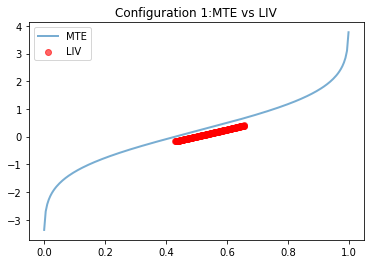

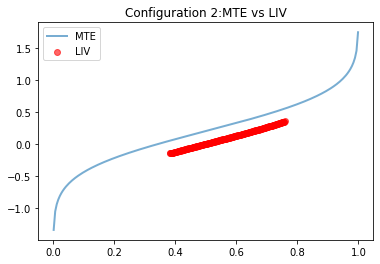

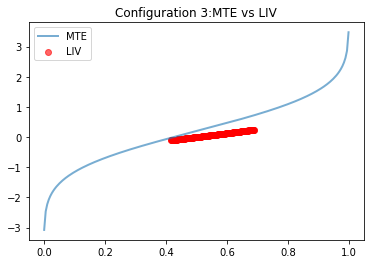

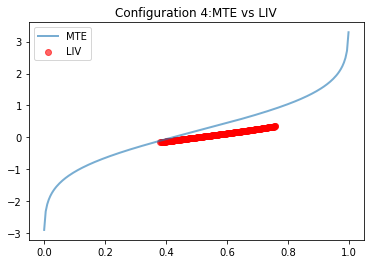

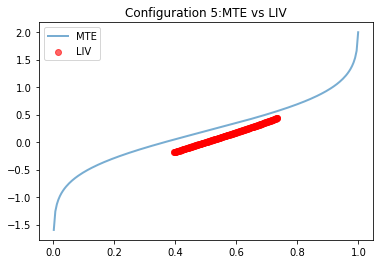

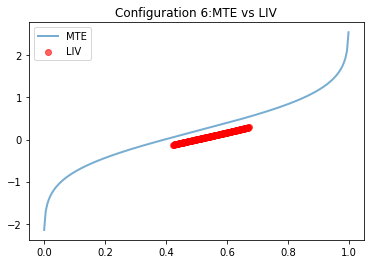

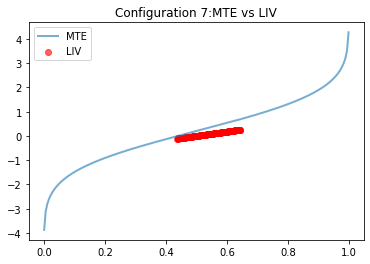

In [134]:
for i in range(1,8,1):
    parameters = globals()["Θ_" + str(i)]
    m = MTE(Θ=parameters)
    l = LIV(Θ=parameters)
    
    fig, ax = plt.subplots()
    ax.plot(m[1], m[0], linewidth=2, alpha=0.6, label='MTE')
    ax.scatter(l[1], l[0],c='red', alpha=0.6, label='LIV')
    ax.legend(loc='best')
    ax.set_title('Configuration '+str(i)+ ':MTE vs LIV')
    plt.show()

# Question 3
## Part A
$$Z \sim U[-0.1,0.1]$$

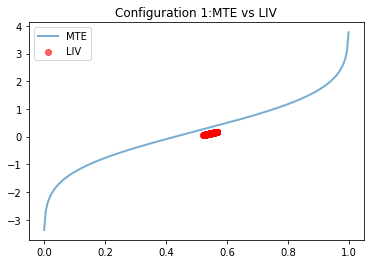

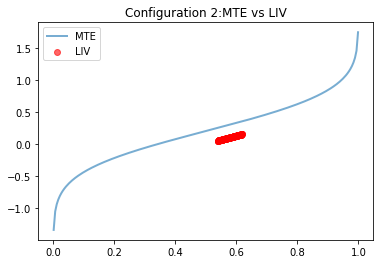

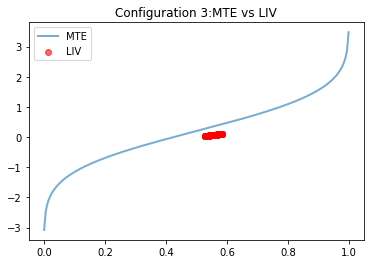

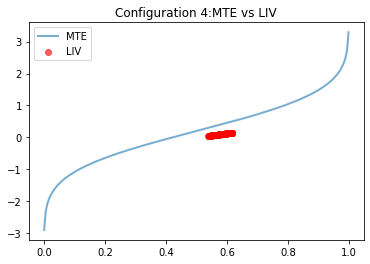

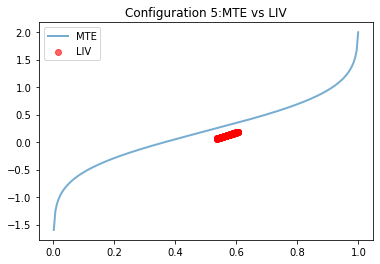

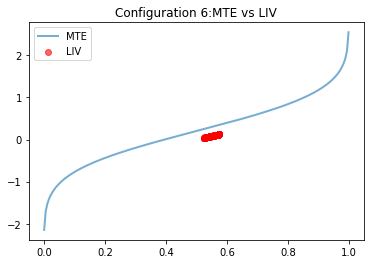

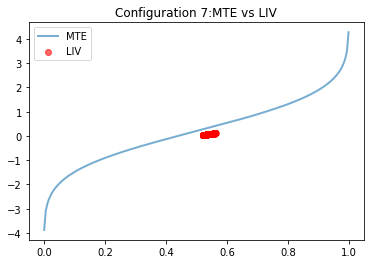

In [135]:
for i in range(1,8,1):
    parameters = globals()["Θ_" + str(i)]
    m = MTE(Θ=parameters)
    l = LIV(values= np.linspace(-0.1,0.1,200), Θ=parameters)
    
    fig, ax = plt.subplots()
    ax.plot(m[1], m[0], linewidth=2, alpha=0.6, label='MTE')
    ax.scatter(l[1], l[0],c='red', alpha=0.6, label='LIV')
    ax.legend(loc='best')
    ax.set_title('Configuration '+str(i)+ ':MTE vs LIV')
    plt.show()

## Part B
$$Z \sim U[0,0]$$

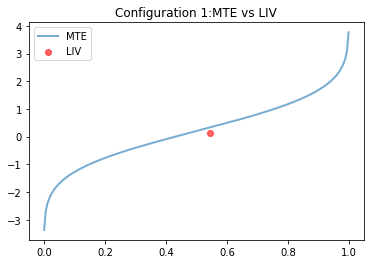

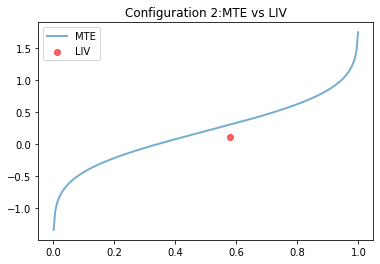

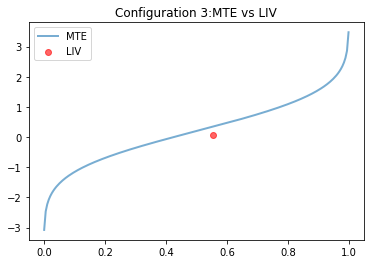

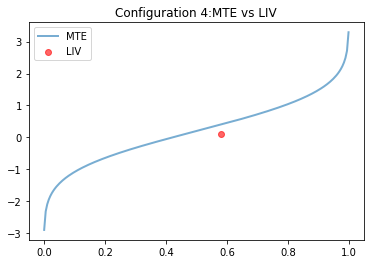

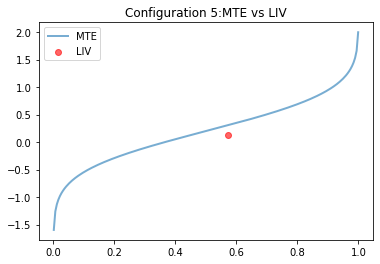

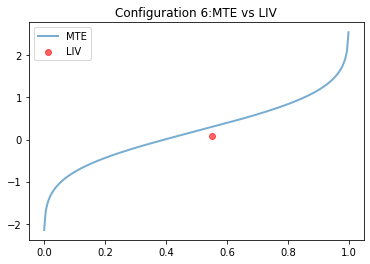

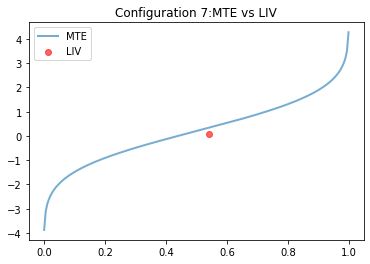

In [136]:
for i in range(1,8,1):
    parameters = globals()["Θ_" + str(i)]
    m = MTE(Θ=parameters)
    l = LIV(values= [0], Θ=parameters)
    
    fig, ax = plt.subplots()
    ax.plot(m[1], m[0], linewidth=2, alpha=0.6, label='MTE')
    ax.scatter(l[1], l[0],c='red', alpha=0.6, label='LIV')
    ax.legend(loc='best')
    ax.set_title('Configuration '+str(i)+ ':MTE vs LIV')
    plt.show()

## Part C
$$Z \sim U[-0.5,-0.3] \cup U[0.3,0.5]$$

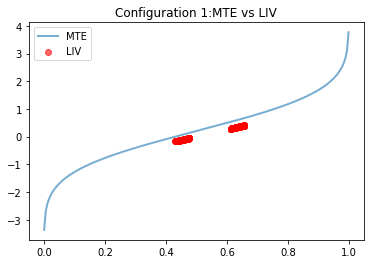

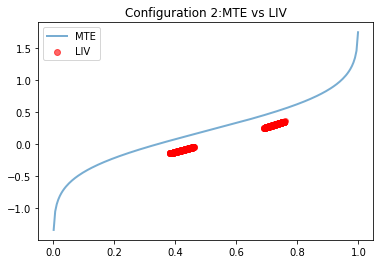

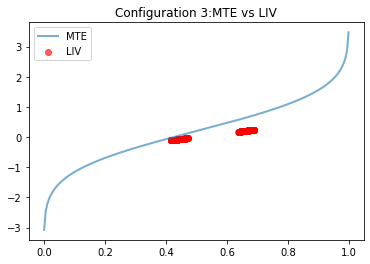

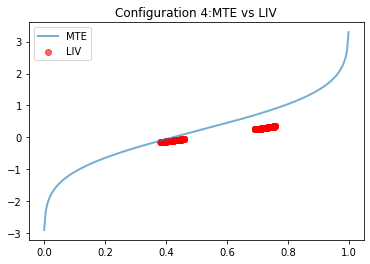

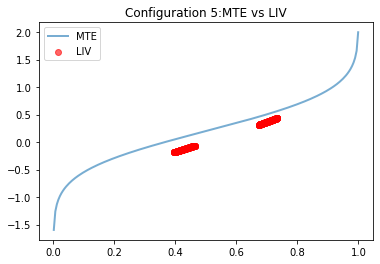

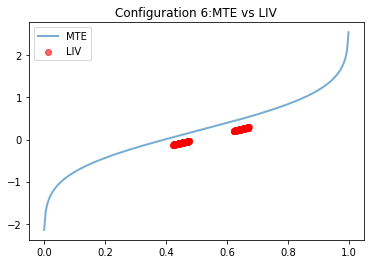

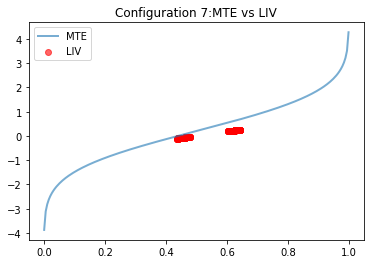

In [137]:
for i in range(1,8,1):
    parameters = globals()["Θ_" + str(i)]
    m = MTE(Θ=parameters)
    l = LIV(values= np.concatenate((np.linspace(-0.5,-0.3,200), np.linspace(0.3,0.5,200),)), Θ=parameters)
    
    fig, ax = plt.subplots()
    ax.plot(m[1], m[0], linewidth=2, alpha=0.6, label='MTE')
    ax.scatter(l[1], l[0],c='red', alpha=0.6, label='LIV')
    ax.legend(loc='best')
    ax.set_title('Configuration '+str(i)+ ':MTE vs LIV')
    plt.show()